# 0. Imports

In [1]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

def plot_horizontal_bar(labels, values, title=None, xlabel=None, ylabel=None, figsize=(8, 6), color="skyblue", save_path=None):
    """
    Plot a horizontal bar chart.

    Parameters
    ----------
    labels : list of str
        Category labels for each bar (e.g., sample names).
    values : list or array-like
        Numeric values corresponding to each label (e.g., counts).
    title : str, optional
        Title of the plot.
    xlabel : str, optional
        Label for the x-axis.
    ylabel : str, optional
        Label for the y-axis.
    figsize : tuple, optional
        Size of the figure (default: (8, 6)).
    color : str, optional
        Bar color (default: "skyblue").
    save_path : str, optional
        If provided, saves the figure to this path instead of displaying.
    """
    # Sort by value for better readability
    sorted_pairs = sorted(zip(labels, values), key=lambda x: x[1])
    sorted_labels, sorted_values = zip(*sorted_pairs)

    plt.figure(figsize=figsize)
    plt.barh(sorted_labels, sorted_values, color=color)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()


In [8]:
import matplotlib.pyplot as plt

def plot_horizontal_bar_with_counts(labels, values, totals, title=None, xlabel=None, figsize=(8, 6), color="skyblue", save_path=None):
    """
    Plot a horizontal bar chart with shared/total labels.

    Parameters
    ----------
    labels : list of str
        Bar labels (e.g., "toolA+toolB").
    values : list of int
        Number of shared elements (overlap).
    totals : list of int
        Total possible elements (e.g., union size or min size).
    title : str
        Plot title.
    xlabel : str
        X-axis label.
    figsize : tuple
        Figure size.
    color : str
        Bar color.
    save_path : str
        If set, saves the figure to this path.
    """
    # Sort by values
    sorted_items = sorted(zip(labels, values, totals), key=lambda x: x[1])
    sorted_labels, sorted_values, sorted_totals = zip(*sorted_items)

    plt.figure(figsize=figsize)
    bars = plt.barh(sorted_labels, sorted_values, color=color)

    # Add "X/Y" labels to each bar
    for bar, x_val, total in zip(bars, sorted_values, sorted_totals):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f"{x_val} / {total}", va='center', fontsize=9)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()


# 1. Consensus in top N interactions

In [2]:
df = pd.read_csv("/home/andrem/GRN-project/results/grn_aggregated_top500.csv")


In [ ]:
from itertools import combinations
import pandas as pd

labels = []
values = []
totals = []

# Compare all pairs of tools
for toolA, toolB in combinations(df["Tool"].unique(), 2):
    # Subsets for each tool
    dfA = df[df["Tool"] == toolA]
    dfB = df[df["Tool"] == toolB]

    # Total = number of rows in A + B
    total = len(dfA) + len(dfB)

    # Merge on (TF, Gene, Patient, Time_Point) to find consensus
    consensus = pd.merge(
        dfA,
        dfB,
        on=["TF", "Gene", "Patient", "Time_Point"],
        how="inner"
    )

    labels.append(f"{toolA}+{toolB}")
    values.append(len(consensus))
    totals.append(total)


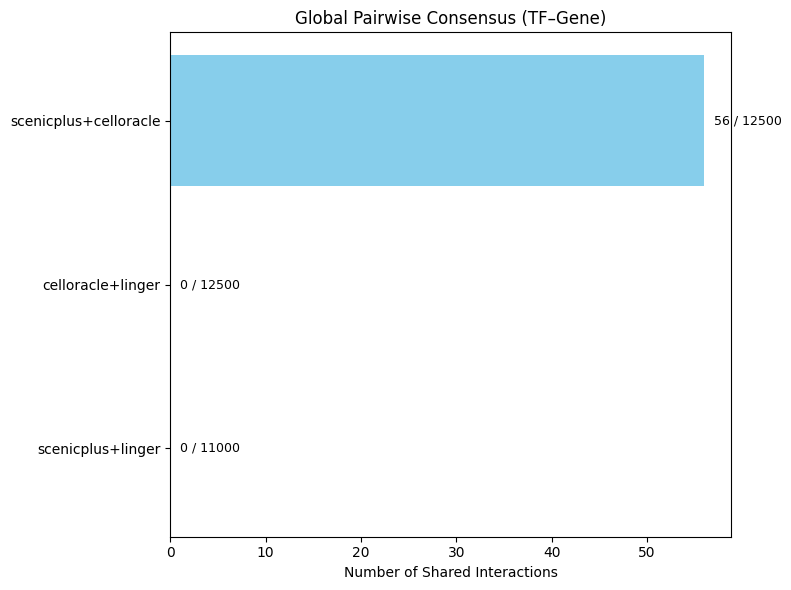

In [12]:
plot_horizontal_bar_with_counts(
    labels=labels,
    values=values,
    totals=totals,
    title="Global Pairwise Consensus (TF–Gene)",
    xlabel="Number of Shared Interactions"
)


In [13]:
from itertools import combinations
import pandas as pd

# Define the tool to analyze
selected_tool = "scenicplus"

# Subset to that tool
tool_df = df[df["Tool"] == selected_tool]

# Group by Time_Point
labels = []
values = []
timepoint_order = ["DX", "REM", "REL"]
timepoint_grouped = []

for time_point in sorted(tool_df["Time_Point"].unique(), key=lambda x: timepoint_order.index(x)):
    tp_df = tool_df[tool_df["Time_Point"] == time_point]

    # Group by patient
    patient_groups = {
        patient: group[["TF", "Gene"]].apply(tuple, axis=1)
        for patient, group in tp_df.groupby("Patient")
    }

    for patientA, patientB in combinations(patient_groups.keys(), 2):
        setA = set(patient_groups[patientA])
        setB = set(patient_groups[patientB])
        shared = setA & setB

        label = f"{patientA}_{time_point} + {patientB}_{time_point}"
        labels.append(label)
        values.append(len(shared))
        timepoint_grouped.append(time_point)


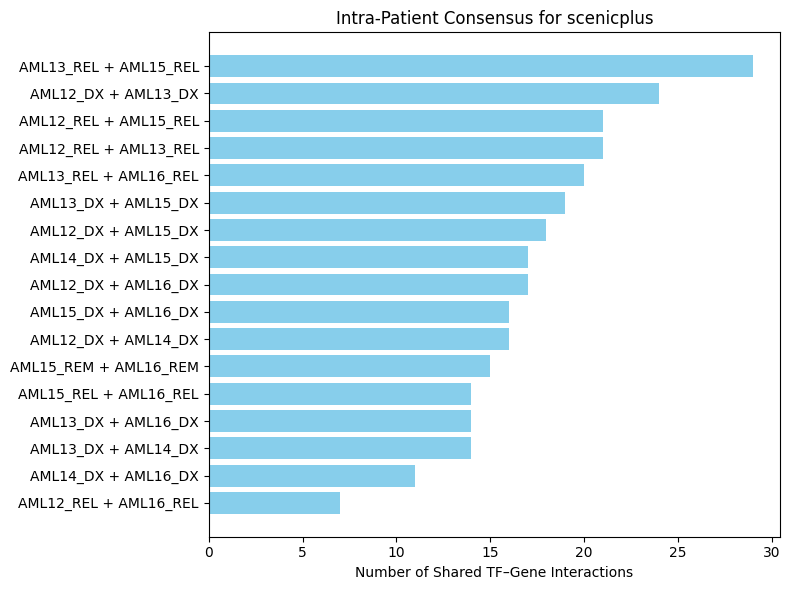

In [15]:
# Sort all three lists together by timepoint
grouped_data = sorted(zip(timepoint_grouped, labels, values), key=lambda x: timepoint_order.index(x[0]))
_, sorted_labels, sorted_values = zip(*grouped_data)

plot_horizontal_bar(
    labels=sorted_labels,
    values=sorted_values,
    title=f"Intra-Patient Consensus for {selected_tool}",
    xlabel="Number of Shared TF–Gene Interactions"
)
